In [43]:
# --- Cell 1: Setup and Constants ---

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Set default plotting style
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 11})

# Constants
T = 1000        # time horizon
H = 20          # feature dimension
kappa = 0.1     # decay / smoothing parameter

# Random seed for reproducibility
np.random.seed(42)

print(f"Initialized constants: T={T}, H={H}, kappa={kappa}")


Initialized constants: T=1000, H=20, kappa=0.1


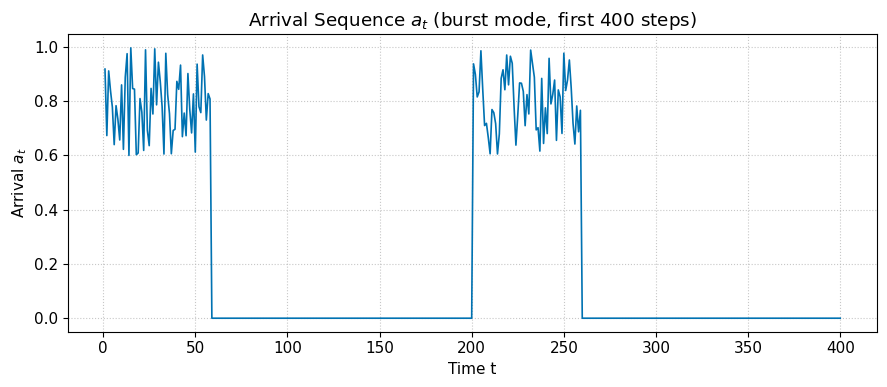

Arrival mode: burst, Mean = 0.182, Std = 0.338


In [44]:
# --- Cell 2: Define multiple arrival sequences a_t ---

def generate_arrivals(T, mode="random", amplitude=1.0):
    """
    Generate an arrival sequence a_t of length T.

    Parameters
    ----------
    T : int
        Length of the sequence.
    mode : str
        Type of arrival sequence:
        - "random": i.i.d. uniform in [0,1)
        - "sin": smooth periodic sinusoidal arrivals
        - "burst": bursts of activity separated by quiet periods
        - "adversarial": alternating high/low pattern to mimic adversarial arrivals
        - "decay": exponentially decaying sequence
    amplitude : float
        Maximum amplitude of the arrivals.

    Returns
    -------
    a : np.ndarray
        Array of shape (T,) representing arrivals a_t.
    """
    if mode == "random":
        a = np.random.rand(T)

    elif mode == "sin":
        t = np.arange(T)
        a = 0.5 * (1 + np.sin(2 * np.pi * t / 100))  # period ≈ 100

    elif mode == "burst":
        a = np.zeros(T)
        for i in range(0, T, 200):
            burst_length = np.random.randint(20, 60)
            a[i:i + burst_length] = np.random.uniform(0.6, 1.0, size=burst_length)

    elif mode == "adversarial":
        a = np.array([(i % 2) for i in range(T)]) * amplitude
        a = a + 0.1 * np.random.randn(T)  # small noise

    elif mode == "decay":
        a = amplitude * np.exp(-0.002 * np.arange(T))

    else:
        raise ValueError(f"Unknown mode: {mode}")

    # Clip to [0,1] range
    a = np.clip(a, 0, 1)
    return a


# Example usage: choose one sequence
a_mode = "burst"   # try: "random", "sin", "burst", "adversarial", "decay"
a = generate_arrivals(T, mode=a_mode)

# Plot only the first 5*H arrivals
plot_len = min(20 * H, T)

plt.figure(figsize=(9, 4))
plt.plot(range(1, plot_len + 1), a[:plot_len], linewidth=1.2)
plt.title(rf"Arrival Sequence $a_t$ ({a_mode} mode, first {plot_len} steps)")
plt.xlabel("Time t")
plt.ylabel("Arrival $a_t$")
plt.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Arrival mode: {a_mode}, Mean = {np.mean(a):.3f}, Std = {np.std(a):.3f}")


In [45]:
# --- Cell 3: Define phi_t^(j) and psi_t^(j) feature matrices ---

def zero_padded(a, t):
    """
    Returns a_t with zero padding for t <= 0.
    Parameters
    ----------
    a : np.ndarray
        Arrival sequence of length T.
    t : int
        Time index (1-indexed).
    """
    return a[t - 1] if t > 0 else 0.0


def compute_phi(a, T, H, kappa):
    """
    Compute matrix Phi with entries:
        phi_t^(j) = kappa * sum_{i=1}^{j-1} (1-kappa)^(i-1) * a_{t-i}
                    + (1-kappa)^(j-1) * a_{t-j}
    with zero padding for a_t when t <= 0.
    Returns
    -------
    Phi : np.ndarray of shape (T, H)
    """
    Phi = np.zeros((T, H))
    for t in range(1, T + 1):
        for j in range(1, H + 1):
            term1 = kappa * sum((1 - kappa) ** (i - 1) * zero_padded(a, t - i)
                                for i in range(1, j))
            term2 = (1 - kappa) ** (j - 1) * zero_padded(a, t - j)
            Phi[t - 1, j - 1] = term1 + term2
    return Phi


def compute_psi(a, T, H, kappa):
    """
    Compute matrix Psi with entries:
        psi_t^(j) = sum_{i=1}^j (1-kappa)^(i-1) * a_{t-i}
    with zero padding for a_t when t <= 0.
    Returns
    -------
    Psi : np.ndarray of shape (T, H)
    """
    Psi = np.zeros((T, H))
    for t in range(1, T + 1):
        for j in range(1, H + 1):
            Psi[t - 1, j - 1] = sum((1 - kappa) ** (i - 1) * zero_padded(a, t - i)
                                    for i in range(1, j + 1))
    return Psi


# Compute both feature matrices for current arrival sequence
Phi = compute_phi(a, T, H, kappa)
Psi = compute_psi(a, T, H, kappa)

print("Computed feature matrices:")
print(f"Phi shape = {Phi.shape}, Psi shape = {Psi.shape}")


Computed feature matrices:
Phi shape = (1000, 20), Psi shape = (1000, 20)


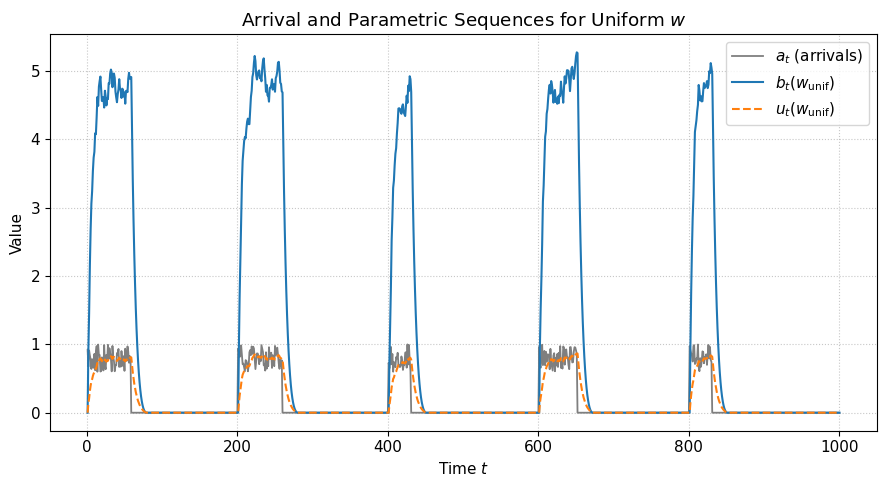

Uniform w sum: 1.0, shape: (20,)


In [46]:
# --- Cell 4: Define u_t(w), b_t(w), and plot for uniform w ---

def u_t(t, w, Phi):
    """
    Compute u_t(w) = <w, phi_t>
    Parameters
    ----------
    t : int (1-indexed)
    w : np.ndarray, shape (H,)
    Phi : np.ndarray, shape (T, H)
    """
    return np.dot(w, Phi[t - 1, :])


def b_t(t, w, Psi):
    """
    Compute b_t(w) = <w, psi_t>
    Parameters
    ----------
    t : int (1-indexed)
    w : np.ndarray, shape (H,)
    Psi : np.ndarray, shape (T, H)
    """
    return np.dot(w, Psi[t - 1, :])


def compute_sequences(w, Phi, Psi):
    """
    Compute u_t(w) and b_t(w) sequences for t=1..T.
    """
    u_seq = np.array([u_t(t, w, Phi) for t in range(1, T + 1)])
    b_seq = np.array([b_t(t, w, Psi) for t in range(1, T + 1)])
    return u_seq, b_seq


# Uniform simplex weight
w_uniform = np.ones(H) / H

# Compute sequences
u_uniform, b_uniform = compute_sequences(w_uniform, Phi, Psi)

# Plot first 5*H points
plot_len = min(50 * H, T)
t_axis = np.arange(1, plot_len + 1)

plt.figure(figsize=(9, 5))
plt.plot(t_axis, a[:plot_len], label=r"$a_t$ (arrivals)", color='tab:gray', linewidth=1.3)
plt.plot(t_axis, b_uniform[:plot_len], label=r"$b_t(w_{\text{unif}})$", color='tab:blue', linestyle='-', linewidth=1.5)
plt.plot(t_axis, u_uniform[:plot_len], label=r"$u_t(w_{\text{unif}})$", color='tab:orange', linestyle='--', linewidth=1.5)

plt.title(r"Arrival and Parametric Sequences for Uniform $w$")
plt.xlabel("Time $t$")
plt.ylabel("Value")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Uniform w sum: {np.sum(w_uniform):.1f}, shape: {w_uniform.shape}")


In [47]:
# --- Cell 5: Define convex cost functions c_t(b, u) ---

def c_linear_neg_b(b, u, t=None):
    """c_t(b, u) = -b  (maximize throughput / minimize negative backlog)."""
    return -b

def c_linear_pos_b(b, u, t=None):
    """c_t(b, u) = +b  (minimize backlog)."""
    return b

def c_quadratic_tracking(b, u, t=None, target=1.0):
    """c_t(b, u) = b + (target - u)^2  (track u_t toward target)."""
    return b + (target - u)**2

def c_weighted_combo(b, u, t=None, s1=1.0, s2=0.5, target=1.0):
    """c_t(b, u) = s1*b + s2*(target - u)^2."""
    return s1 * b + s2 * (target - u)**2

def c_time_variant_sin(b, u, t, s1=1.0, s2=0.5, period=200):
    """c_t(b, u) = (s1 + 0.5*sin(2πt/period))*b + s2*(1 - u)^2 (periodic cost variation)."""
    weight_t = s1 + 0.5 * np.sin(2 * np.pi * t / period)
    return weight_t * b + s2 * (1 - u)**2

def c_time_variant_adversarial(b, u, t, s1=1.0, s2=0.5):
    """c_t(b, u) = s1*(-1)^t * b + s2*(1 - u)^2 (alternating adversarial sign)."""
    return ((-1)**t) * s1 * b + s2 * (1 - u)**2


# --- Registry of available cost functions ---
COST_FUNCTIONS = {
    "linear_-b": c_linear_neg_b,
    "linear_+b": c_linear_pos_b,
    "tracking": c_quadratic_tracking,
    "weighted": c_weighted_combo,
    "sin_time_variant": c_time_variant_sin,
    "adversarial_time_variant": c_time_variant_adversarial,
}

print("Available cost functions:")
for k in COST_FUNCTIONS:
    print(f"  - {k}")


Available cost functions:
  - linear_-b
  - linear_+b
  - tracking
  - weighted
  - sin_time_variant
  - adversarial_time_variant


In [48]:
# --- Cell 6: Verify convexity and CVXPY compliance of all c_t(b, u) functions ---

import cvxpy as cp

def check_convexity_cvxpy(cost_fn, name, s1=1.0, s2=0.5, target=1.0):
    """
    Checks convexity and DCP compliance of a cost function using CVXPY.
    Prints results and returns boolean for convexity.
    """
    b = cp.Variable(name="b")
    u = cp.Variable(name="u")
    t = 10  # example time index for time-variant ones

    try:
        # Build expression safely using the given function
        expr = cost_fn(b, u, t)
        
        # Wrap in objective to check convexity
        obj = cp.Minimize(expr)
        prob = cp.Problem(obj)
        
        print(f"{name:30s} -> DCP compliant:", prob.is_dcp(), "| Convex:", expr.is_convex())
    except Exception as e:
        print(f"{name:30s} -> ERROR:", str(e))


# Run convexity checks on all defined functions
print("Checking convexity and DCP compliance:\n")

check_convexity_cvxpy(c_linear_neg_b, "linear_-b")
check_convexity_cvxpy(c_linear_pos_b, "linear_+b")
check_convexity_cvxpy(c_quadratic_tracking, "tracking")
check_convexity_cvxpy(lambda b, u, t: c_weighted_combo(b, u, t, s1=1.0, s2=0.5), "weighted_combo")
check_convexity_cvxpy(lambda b, u, t: c_time_variant_sin(b, u, t, s1=1.0, s2=0.5), "sin_time_variant")
check_convexity_cvxpy(lambda b, u, t: c_time_variant_adversarial(b, u, t, s1=1.0, s2=0.5), "adversarial_time_variant")


Checking convexity and DCP compliance:

linear_-b                      -> DCP compliant: True | Convex: True
linear_+b                      -> DCP compliant: True | Convex: True
tracking                       -> DCP compliant: True | Convex: True
weighted_combo                 -> DCP compliant: True | Convex: True
sin_time_variant               -> DCP compliant: True | Convex: True
adversarial_time_variant       -> DCP compliant: True | Convex: True


In [54]:
# --- Final Cell 7: Full pipeline: generate a_t → compute Φ,Ψ → optimize w → plot sequences + costs ---

def run_storage_optimization(
    a_mode="random",
    cost_key="weighted",
    cost_kwargs=None,
    T=T,
    H=H,
    kappa=kappa,
    amplitude=1.0,
    plot_len=None,
    verbose=False
):
    """
    End-to-end pipeline:
        1. Generate a_t
        2. Compute Φ, Ψ
        3. Solve for w* minimizing sum_t c_t(b_t(w), u_t(w))
        4. Plot a_t, b_t(w), u_t(w)
        5. Plot per-step costs
        6. Print optimal w*
    """
    if cost_kwargs is None:
        cost_kwargs = {}

    # --- 1. Generate arrivals ---
    a = generate_arrivals(T, mode=a_mode, amplitude=amplitude)

    # --- 2. Compute Φ and Ψ ---
    Phi = compute_phi(a, T, H, kappa)
    Psi = compute_psi(a, T, H, kappa)

    # --- 3. Solve optimization ---
    if cost_key not in COST_FUNCTIONS:
        raise ValueError(f"Unknown cost_key '{cost_key}'. Available: {list(COST_FUNCTIONS.keys())}")
    cost_fn = COST_FUNCTIONS[cost_key]

    w = cp.Variable(H, nonneg=True)
    constraints = [cp.sum(w) == 1]
    terms = [cost_fn(Psi[t, :] @ w, Phi[t, :] @ w, t + 1, **cost_kwargs) for t in range(T)]
    total_cost = cp.sum(cp.hstack(terms))
    prob = cp.Problem(cp.Minimize(total_cost), constraints)
    prob.solve(verbose=verbose)

    # --- 4. Extract sequences ---
    w_star = np.array(w.value).flatten()
    b_star = Psi @ w_star
    u_star = Phi @ w_star

    # Uniform baseline
    w_unif = np.ones(H) / H
    b_unif = Psi @ w_unif
    u_unif = Phi @ w_unif

    # --- 5. Compute per-step costs ---
    c_opt = np.array([cost_fn(b_star[t], u_star[t], t + 1, **cost_kwargs) for t in range(T)])
    c_unif = np.array([cost_fn(b_unif[t], u_unif[t], t + 1, **cost_kwargs) for t in range(T)])

    # --- 6. Plot sequences (a_t, b_t, u_t) ---
    if plot_len is None:
        plot_len = min(50 * H, T)
    t_axis = np.arange(1, plot_len + 1)

    plt.figure(figsize=(9, 5))
    plt.plot(t_axis, a[:plot_len], label=r"$a_t$", color="tab:gray", linewidth=1.3)
    plt.plot(t_axis, b_unif[:plot_len], label=r"$b_t(w_{\text{unif}})$", color="tab:blue", linestyle="-.")
    plt.plot(t_axis, u_unif[:plot_len], label=r"$u_t(w_{\text{unif}})$", color="tab:cyan", linestyle="--")
    plt.plot(t_axis, b_star[:plot_len], label=r"$b_t(w^*)$", color="tab:red", linewidth=2.0)
    plt.plot(t_axis, u_star[:plot_len], label=r"$u_t(w^*)$", color="tab:orange", linestyle="--", linewidth=2.0)
    plt.title(rf"$a_t$, $b_t(w)$, $u_t(w)$ for a_mode='{a_mode}', cost='{cost_key}'")
    plt.xlabel("Time $t$")
    plt.ylabel("Value")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 7. Plot per-step costs ---
    plt.figure(figsize=(9, 4))
    plt.plot(t_axis, c_unif[:plot_len], label=r"$c_t(b_t,u_t)$ (uniform $w$)", color="tab:blue", linestyle="--")
    plt.plot(t_axis, c_opt[:plot_len], label=r"$c_t(b_t,u_t)$ (optimal $w^*$)", color="tab:red", linewidth=1.8)
    plt.title(rf"Per-step cost comparison for cost='{cost_key}'")
    plt.xlabel("Time $t$")
    plt.ylabel(r"$c_t(b_t,u_t)$")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 8. Print summary ---
    print("\n──────────────────────────────")
    print(f"Arrival mode:   {a_mode}")
    print(f"Cost function:  {cost_key}")
    print(f"Total cost (uniform): {np.sum(c_unif):.4f}")
    print(f"Total cost (optimal): {np.sum(c_opt):.4f}")
    print("Optimal w*:")
    print(np.round(w_star, 4))
    print(f"Sum(w*): {np.sum(w_star):.4f}")
    print("──────────────────────────────")

    return {
        "a": a,
        "Phi": Phi,
        "Psi": Psi,
        "w_star": w_star,
        "b_star": b_star,
        "u_star": u_star,
        "c_opt": c_opt,
        "c_unif": c_unif,
        "objective": prob.value,
    }


# --- Example usage ---
# result = run_storage_optimization(
#     a_mode="adversarial",
#     cost_key="weighted",
#     cost_kwargs={"s1": 1.0, "s2": 0.5, "target": 1.0},
#     verbose=True
# )


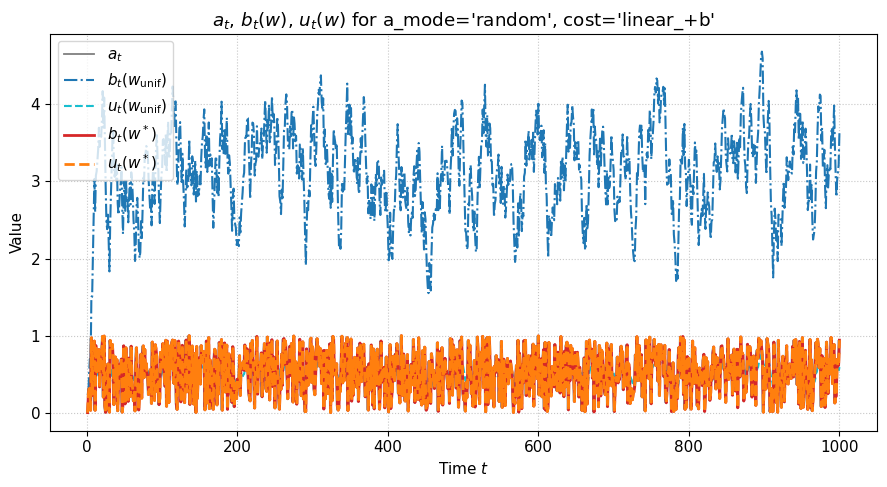

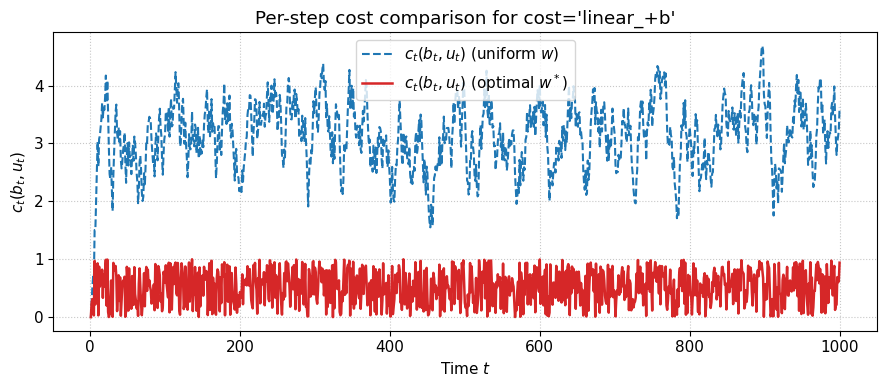


──────────────────────────────
Arrival mode:   random
Cost function:  linear_+b
Total cost (uniform): 3120.4406
Total cost (optimal): 518.6259
Optimal w*:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


In [55]:
# 1️⃣ Simple backlog minimization
result = run_storage_optimization(a_mode="random", cost_key="linear_+b")

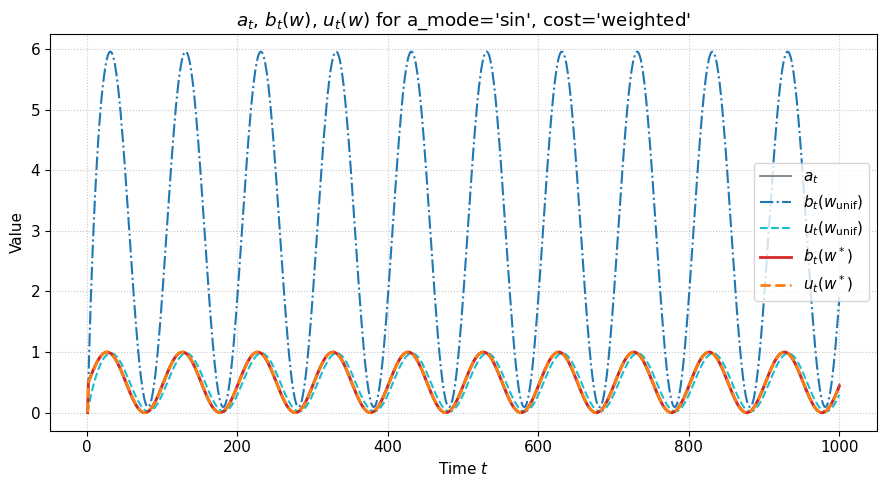

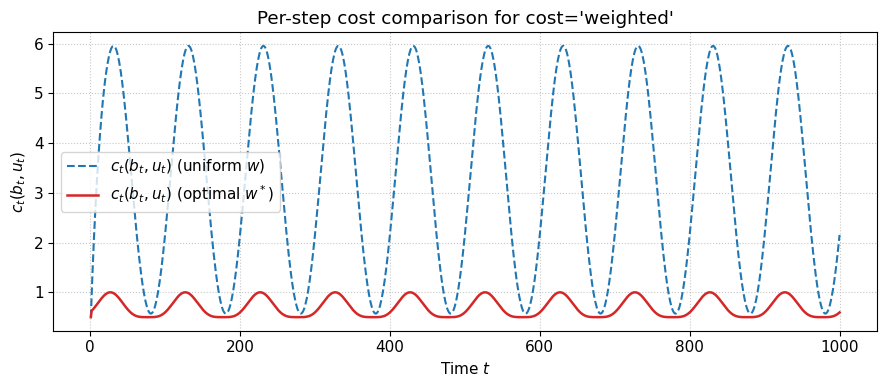


──────────────────────────────
Arrival mode:   sin
Cost function:  weighted
Total cost (uniform): 3195.8754
Total cost (optimal): 687.3902
Optimal w*:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


In [56]:
# 2️⃣ Balanced tracking (static)
result = run_storage_optimization(a_mode="sin", cost_key="weighted",
                                  cost_kwargs={"s1": 1.0, "s2": 0.5, "target": 1.0})

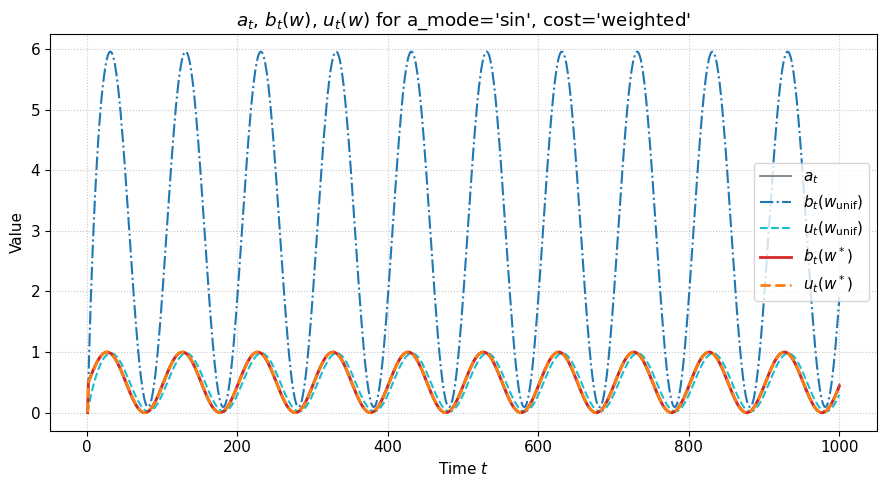

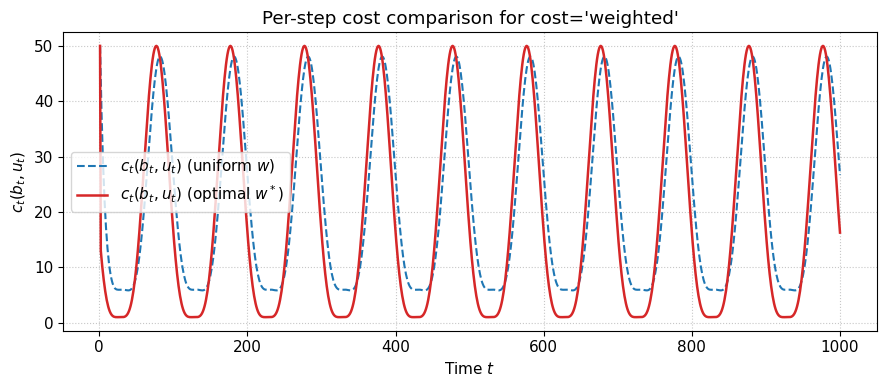


──────────────────────────────
Arrival mode:   sin
Cost function:  weighted
Total cost (uniform): 21395.0108
Total cost (optimal): 19285.4123
Optimal w*:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


In [59]:
result = run_storage_optimization(a_mode="sin", cost_key="weighted",
                                  cost_kwargs={"s1": 1.0, "s2": 50, "target": 1.0})

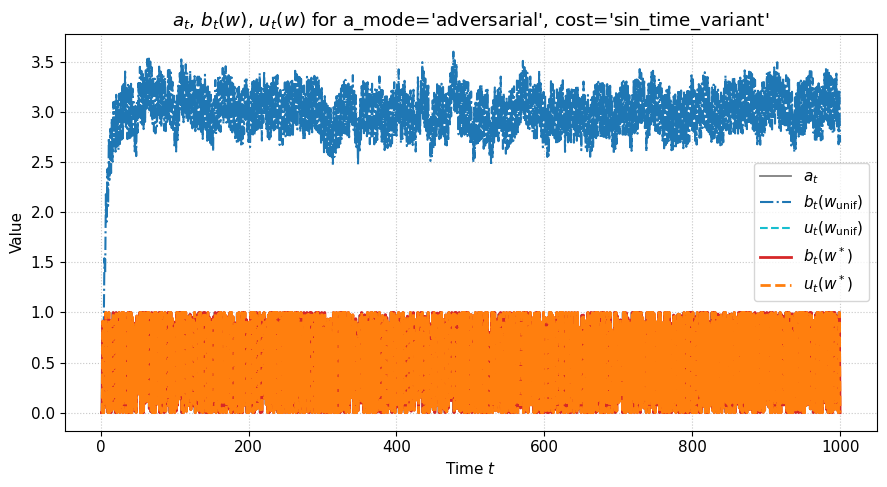

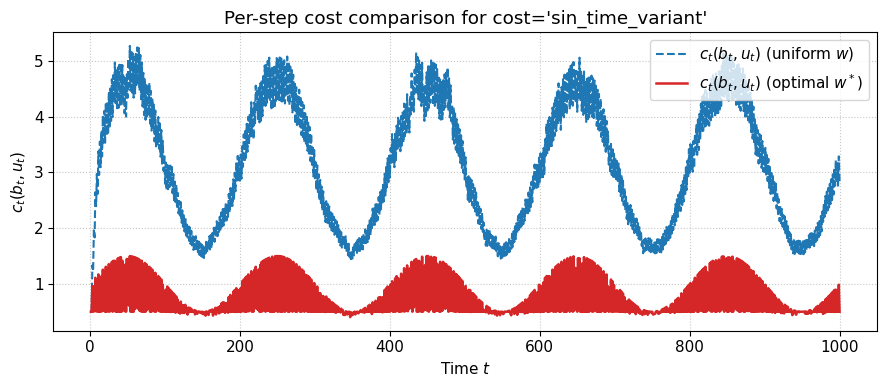


──────────────────────────────
Arrival mode:   adversarial
Cost function:  sin_time_variant
Total cost (uniform): 3125.1650
Total cost (optimal): 732.2091
Optimal w*:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


In [58]:
# 3️⃣ Periodic time-varying cost
result = run_storage_optimization(a_mode="adversarial", cost_key="sin_time_variant",
                                  cost_kwargs={"s1": 1.0, "s2": 0.5, "period": 200})

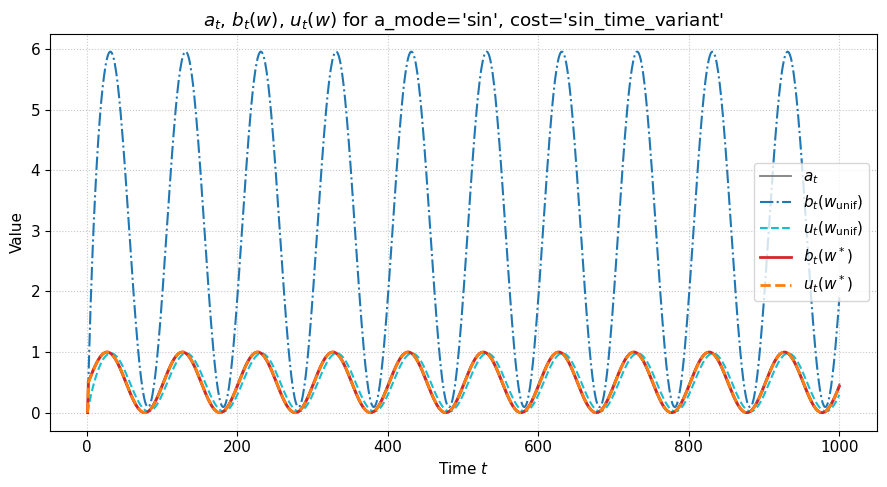

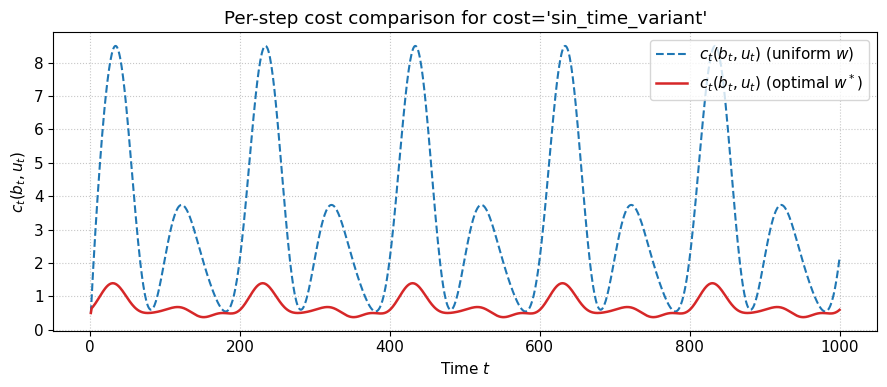


──────────────────────────────
Arrival mode:   sin
Cost function:  sin_time_variant
Total cost (uniform): 3195.0155
Total cost (optimal): 687.3828
Optimal w*:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


In [60]:
# 3️⃣ Periodic time-varying cost
result = run_storage_optimization(a_mode="sin", cost_key="sin_time_variant",
                                  cost_kwargs={"s1": 1.0, "s2": 0.5, "period": 200})